# Optimal control with piecewise constant parametrization

In [1]:
import sys
sys.path.append('/home/llguo/PycharmProjects/c3/')

In [2]:
import numpy as np
import pytest
from c3.c3objs import Quantity
from c3.generator.generator import Generator
from c3.generator.devices import (
    LO,
    AWG,
    Mixer,
    DigitalToAnalog,
    VoltsToHertz,
)
from c3.signal.pulse import Envelope, Carrier
from c3.libraries.envelopes import pwc
from c3.libraries import hamiltonians
from c3.signal.gates import Instruction
from c3.model import Model
from c3.libraries import chip
from c3.parametermap import ParameterMap
from c3.experiment import Experiment

2022-06-04 22:42:55.671082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 22:42:55.671124: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
sim_res = 100e9  # Resolution for numerical simulation
awg_res = 2e9  # Realistic, limited resolution of an AWG

lo = LO(name="lo", resolution=sim_res, outputs=1)
awg = AWG(name="awg", resolution=awg_res, outputs=1)

dac = DigitalToAnalog(name="dac", resolution=sim_res, inputs=1, outputs=1)
mixer = Mixer(name="mixer", inputs=2, outputs=1)
v_to_hz = VoltsToHertz(
    name="v_to_hz",
    V_to_Hz=Quantity(value=1e9, min_val=0.9e9, max_val=1.1e9, unit="Hz/V"),
    inputs=1,
    outputs=1,
)

generator = Generator(
    devices={
        "LO": lo,
        "AWG": awg,
        "DigitalToAnalog": dac,
        "Mixer": mixer,
        "VoltsToHertz": v_to_hz,
    },
    chains={
        "d1": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        },
    },
)

2022-06-04 22:42:58.535948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 22:42:58.536661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 22:42:58.536742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-04 22:42:58.536814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-04 22:42:58.536886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [4]:
t_final = 7e-9  # Time for single qubit gates
slices = int(t_final * awg_res)

pwc_params = {
    "inphase": Quantity(value=np.random.randn(slices), unit="V"),
    "quadrature": Quantity(value=np.random.randn(slices), unit="V"),
    "amp": Quantity(value=1.0, unit="V"),
    "xy_angle": Quantity(
        value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"
    ),
    "freq_offset": Quantity(value=0, min_val=-5 * 1e6, max_val=5 * 1e6, unit="Hz 2pi"),
}

pwc_env_single = Envelope(
    name="pwc",
    desc="piecewise constant",
    params=pwc_params,
    shape=pwc,
)

lo_freq_q1 = 5e9
carrier_parameters = {
    "freq": Quantity(value=lo_freq_q1, min_val=4.5e9, max_val=6e9, unit="Hz 2pi"),
    "framechange": Quantity(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
}
carr = Carrier(
    name="carrier", desc="Frequency of the local oscillator", params=carrier_parameters
)

pulse_gate = Instruction(name="rx90p", t_start=0.0, t_end=t_final, channels=["d1"])
pulse_gate.add_component(pwc_env_single, "d1")
pulse_gate.add_component(carr, "d1")

In [5]:
q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Quantity(
        value=5e9,
        min_val=4.995e9,
        max_val=5.005e9,
        unit="Hz 2pi",
    ),
    anhar=Quantity(
        value=-150e6,
        min_val=-380e6,
        max_val=-120e6,
        unit="Hz 2pi",
    ),
    hilbert_dim=5,
)

drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive,
)
phys_components = [q1]
line_components = [drive]

model = Model(phys_components, line_components)
model.set_dressed(True)

In [6]:
parameter_map = ParameterMap(
    instructions=[pulse_gate], model=model, generator=generator
)

# ### MAKE EXPERIMENT
simulation = Experiment(pmap=parameter_map)

In [7]:
gateset_opt_map =   [
    [
      ("rx90p", "d1", "pwc", "amp"),
    ],
    [
      ("rx90p", "d1", "pwc", "inphase"),
    ],
    [
      ("rx90p", "d1", "pwc", "quadrature"),
  ]
]

parameter_map.set_opt_map(gateset_opt_map)

In [8]:
parameter_map.print_parameters()

rx90p-d1-pwc-amp                      : 1.000 V 
rx90p-d1-pwc-inphase                  : 2.059 V 1.579 V -787.603 mV -1.161 V -1.091 V 1.034 V 831.274 mV 574.192 mV 2.222 V -318.956 mV -3.135 V 1.346 V -868.113 mV 511.328 mV 
rx90p-d1-pwc-quadrature               : 724.967 mV 762.031 mV -479.805 mV -669.289 mV 694.266 mV -651.397 mV -791.170 mV -157.898 mV -418.052 mV -709.279 mV 1.130 V -403.900 mV -1.232 V -281.704 mV 



In [9]:
import os
import tempfile
from c3.optimizers.optimalcontrol import OptimalControl
from c3.libraries.fidelities import unitary_infid_set
from c3.libraries.algorithms import lbfgs

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=unitary_infid_set,
    fid_subspace=["Q1"],
    pmap=parameter_map,
    algorithm=lbfgs,
    options={"maxfun" : 150},
    run_name="better_X90"
)
opt.set_exp(simulation)

In [10]:
parameter_map.get_parameters_scaled()

<tf.Tensor: shape=(29,), dtype=float64, numpy=
array([-5.55111512e-16,  8.69335491e-01,  7.06316681e-01, -9.68853550e-02,
       -2.23492750e-01, -1.99772874e-01,  5.21178056e-01,  4.52536738e-01,
        3.65286892e-01,  9.24583191e-01,  6.21662821e-02, -8.93598627e-01,
        6.27211761e-01, -1.24208930e-01,  3.43951898e-01,  6.01223834e-01,
        6.29747680e-01, -3.25950479e-01, -4.71774385e-01,  5.77596953e-01,
       -4.58004850e-01, -5.65572216e-01, -7.82152360e-02, -2.78426213e-01,
       -5.02549706e-01,  9.13027311e-01, -2.67534852e-01, -9.05154507e-01,
       -1.73494743e-01])>

In [11]:
opt.optimize_controls()

C3:STATUS:Saving as: /tmp/tmpeln1thie/c3logs/better_X90/2022_06_04_T_22_43_09/open_loop.c3log


In [12]:
opt.current_best_goal

9.35164825432988e-06

In [13]:
import matplotlib.pyplot as plt
def plot_controls(pmap):
    for gate, instruction in pmap.instructions.items():
        fig, axs = plt.subplots(2)
        axs[0].set_title(gate.replace("_", "-"))
        legends = [[], []]
        for chan, channel in instruction.comps.items():
            for com, component in channel.items():
                if "t_final" in component.params:
                    ts = np.linspace(0, t_final, slices)
                    shape = component.get_shape_values(ts)
                    ax = axs[0]
                    ax.plot(ts[:len(shape)]/1e-9, np.real(shape))
                    ax.plot(ts[:len(shape)]/1e-9, np.imag(shape))
                    legends[0].append((chan, com.replace("_", "-"), "I"))
                    legends[0].append((chan, com.replace("_", "-"), "Q"))
                    ax = axs[1]
                    ax.plot(ts[:len(shape)]/1e-9, np.abs(shape))
                    ax.plot(ts[:len(shape)]/1e-9, np.angle(shape))
                    legends[1].append((chan, com.replace("_", "-"), "Abs"))
                    legends[1].append((chan, com.replace("_", "-"), "Phase"))
        ax = axs[0]
        ax.legend(legends[0])
        ax = axs[1]
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Amplitude [normalized]")
        ax.legend(legends[1])

def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

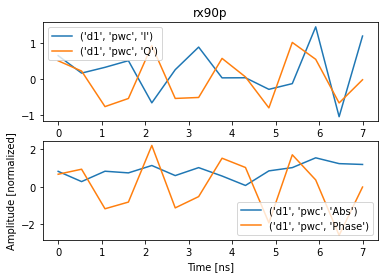

In [14]:
plot_controls(parameter_map)

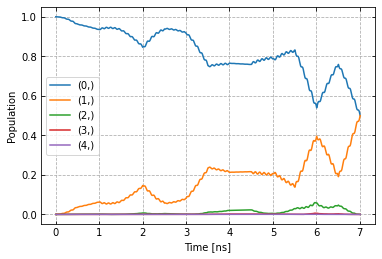

In [15]:
plot_dynamics(simulation, model.get_init_state(), ["rx90p"])